In [1]:
from time import time
import random

import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

In [2]:
df_raw=pd.read_csv('../Dataset/training_tweets.csv',encoding = "ISO-8859-1", header=None)

In [3]:
df_raw.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
 # As the data has no column titles, we will add our own
df_raw.columns = ["label", "time", "date", "query", "username", "text"]

In [5]:
df_raw['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [6]:
df = df_raw[['label', 'text']]
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
df_pos = df[df['label'] == 4]
df_neg = df[df['label'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [8]:
# Concatenating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos, df_neg])
len(df)

1600000

# Cleaning and Preprocessing the data

# Tokenization

In [10]:
from nltk.tokenize import TweetTokenizer

In [11]:
start_time = time()


# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = df['text'].tolist()
Y = df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
        
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 152.803946018219


[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'],
  1),
 (['im',
   'meeting',
   'up',
   'with',
   'one',
   'of',
   'my',
   'besties',
   'tonight',
   '!',
   'Cant',
   'wait',
   '!',
   '!',
   '-',
   'GIRL',
   'TALK',
   '!',
   '!'],
  1),
 (['@DaRealSunisaKim',
   'Thanks',
   'for',
   'the',
   'Twitter',
   'add',
   ',',
   'Sunisa',
   '!',
   'I',
   'got',
   'to',
   'meet',
   'you',
   'once',
   'at',
   'a',
   'HIN',
   'show',
   'here',
   'in',
   'the',
   'DC',
   'area',
   'and',
   'you',
   'were',
   'a',
   'sweetheart',
   '.'],
  1),
 (['Being',
   'sick',
   'can',
   'be',
   'really',
   'cheap',
   'when',
   'it',
   'hurts',
   'too',
   'much',
   'to',
   'eat',
   'real',
   'food',
   'Plus',
   ',',
   'your',
   'friends',
   'make',
   'you',
   'soup'],
  1),
 (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]

# Lemmatization

In [12]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[('I', 'PRP'), ('LOVE', 'VBP'), ('@Health4UandPets', 'NNS'), ('u', 'JJ'), ('guys', 'NNS'), ('r', 'VBP'), ('the', 'DT'), ('best', 'JJS'), ('!', '.'), ('!', '.')]


In [ ]:
# def lemmatize_sentence(tokens):
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_sentence = []
#     for word, tag in pos_tag(tokens):
#         # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
#         # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
#         if tag.startswith('NN'):
#             pos = 'n'
#         elif tag.startswith('VB'):
#             pos = 'v'
#         else:
#             pos = 'a'
#         lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
#     return lemmatized_sentence

# # Previewing the WordNetLemmatizer() output
# print(lemmatize_sentence(data[0][0]))

# Cleaning the data

In [13]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

In [14]:
# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))


['love', 'guy', 'best']


In [16]:
start_time = time()

# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

print('Removed Noise, CPU Time:', time() - start_time)


Removed Noise, CPU Time: 2073.1492941379547


In [ ]:
# start_time = time()

# final_data = []

# # Transforming the data to fit the input structure of the Naive Bayesian classifier
# for tokens, label in cleaned_tokens_list:
#     final_data.append((list_to_dict(tokens), label))
    
# print('Data Prepared for model, CPU Time:', time() - start_time)

# # Previewing our final (tokenized, cleaned and lemmatized) data list
# final_data[:5]

# Deep Learning model- LSTM

In [16]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
# Defining a handy function in order to load a given glove file

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


In [18]:
# Loading the 50-dimensional GloVe embeddings
# This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [19]:
word_to_index['hello']

176468

In [20]:
word_to_vec_map['hello']

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ])

In [21]:
word_to_index['unk']

372306

# Data transformation

In [20]:
start_time = time()

unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate contiguously occuring
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

        
# Here we will utilize the already computed 'cleaned_tokens_list' variable
   
print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 0.0010259151458740234
max_len: 27
Data Prepared for model, CPU Time: 9.979662895202637
[[226278. 169725.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.]
 [239785. 269953. 372306. 361859.  91041. 382320. 161844. 352214.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.]
 [357161. 368306.  46173. 372306. 160418. 239785. 179025. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.]
 [330826. 302352.  97698. 184322. 251645. 132701. 302292. 151204. 286963.
  154049. 231458. 338210.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      

# Building the model

In [21]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split

In [22]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer


In [28]:
# Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
# that finally feed into a sigmoid layer that generates our desired output betwene 0 and 1.

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 50)            20000050  
_________________________________________________________________
bidirectional (Bidirectional (None, 27, 256)           183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [29]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Split the data 

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [29]:
len(X_train)

1280000

In [30]:
len(X_test)

320000

# Training the model

In [37]:
# Setting a batch size of 20 and training our model for 20 epochs

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 5, batch_size = 512, shuffle=True)

Epoch 1/5
2500/2500 [==============================] - 3067s 1s/step - loss: 0.4750 - accuracy: 0.7687 - val_loss: 0.4728 - val_accuracy: 0.7706
Epoch 2/5
2500/2500 [==============================] - 3008s 1s/step - loss: 0.4611 - accuracy: 0.7778 - val_loss: 0.4665 - val_accuracy: 0.7750
Epoch 3/5
2500/2500 [==============================] - 2865s 1s/step - loss: 0.4491 - accuracy: 0.7854 - val_loss: 0.4600 - val_accuracy: 0.7794
Epoch 4/5
2500/2500 [==============================] - 3036s 1s/step - loss: 0.4383 - accuracy: 0.7917 - val_loss: 0.4596 - val_accuracy: 0.7801
Epoch 5/5
2500/2500 [==============================] - 2866s 1s/step - loss: 0.4273 - accuracy: 0.7979 - val_loss: 0.4590 - val_accuracy: 0.7805


In [33]:
import matplotlib.pyplot as plt
# Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

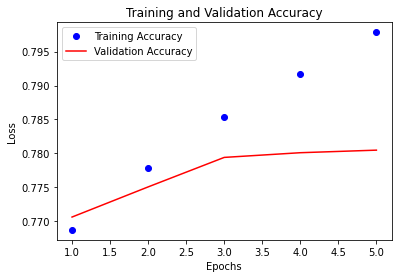

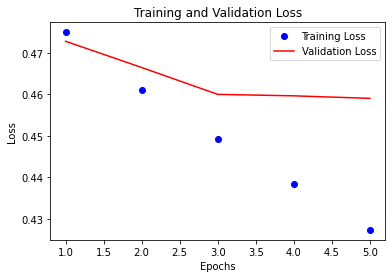

In [41]:
# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)

In [42]:
model.evaluate(X_test, Y_test, batch_size=512)

625/625 [==============================] - 183s 293ms/step - loss: 0.4590 - accuracy: 0.7805


[0.4590336084365845, 0.7804531455039978]

In [43]:
model.save("BiLSTM_1.h5")

# Improving the LSTM Model

In [25]:
# Model building- Dropout
import tensorflow
tensorflow.keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 50)            20000050  
_________________________________________________________________
dropout (Dropout)            (None, 27, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 27, 256)           183296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
______________________________________

In [26]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
#originally 20
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 5, batch_size = 1024, shuffle=True)

Epoch 1/5
1250/1250 [==============================] - 3076s 2s/step - loss: 0.5848 - accuracy: 0.6844 - val_loss: 0.5335 - val_accuracy: 0.7270
Epoch 2/5
1250/1250 [==============================] - 2747s 2s/step - loss: 0.5541 - accuracy: 0.7104 - val_loss: 0.5160 - val_accuracy: 0.7398
Epoch 3/5
1250/1250 [==============================] - 2721s 2s/step - loss: 0.5402 - accuracy: 0.7211 - val_loss: 0.5023 - val_accuracy: 0.7507
Epoch 4/5
1250/1250 [==============================] - 2753s 2s/step - loss: 0.5309 - accuracy: 0.7283 - val_loss: 0.4958 - val_accuracy: 0.7544
Epoch 5/5
1250/1250 [==============================] - 2805s 2s/step - loss: 0.5246 - accuracy: 0.7331 - val_loss: 0.4908 - val_accuracy: 0.7580


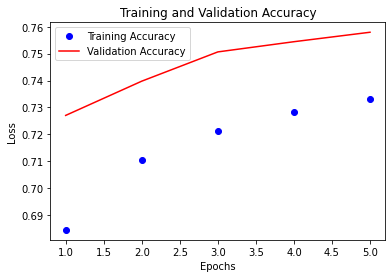

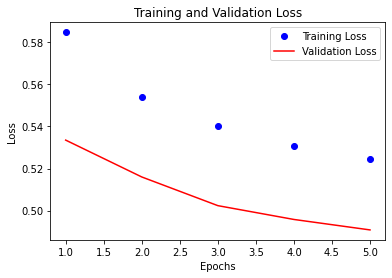

In [34]:
plot_acc_loss(model_dropout.history)

In [37]:
model_dropout.evaluate(X_test, Y_test, batch_size=1024)

313/313 [==============================] - 204s 651ms/step - loss: 0.4908 - accuracy: 0.7580


[0.49079614877700806, 0.757965624332428]

In [51]:
model_dropout.save("BiLSTM_2.h5")

In [52]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 5, batch_size = 1024, shuffle=True)

Epoch 1/5
1250/1250 [==============================] - 2818s 2s/step - loss: 0.5187 - accuracy: 0.7372 - val_loss: 0.4851 - val_accuracy: 0.7628
Epoch 2/5
1250/1250 [==============================] - 2759s 2s/step - loss: 0.5143 - accuracy: 0.7407 - val_loss: 0.4842 - val_accuracy: 0.7643
Epoch 3/5
1250/1250 [==============================] - 2774s 2s/step - loss: 0.5113 - accuracy: 0.7427 - val_loss: 0.4790 - val_accuracy: 0.7664
Epoch 4/5
1250/1250 [==============================] - 2795s 2s/step - loss: 0.5076 - accuracy: 0.7452 - val_loss: 0.4773 - val_accuracy: 0.7683
Epoch 5/5
1250/1250 [==============================] - 2765s 2s/step - loss: 0.5055 - accuracy: 0.7466 - val_loss: 0.4765 - val_accuracy: 0.7688


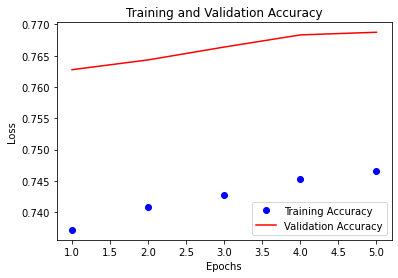

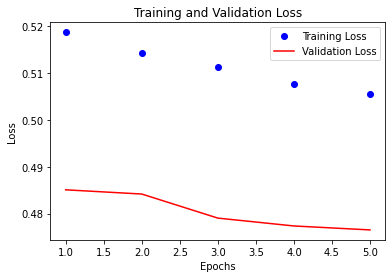

In [53]:
plot_acc_loss(model_dropout.history)

In [54]:
model_dropout.evaluate(X_test, Y_test, batch_size=1024)

313/313 [==============================] - 185s 592ms/step - loss: 0.4765 - accuracy: 0.7688


[0.47649747133255005, 0.7687531113624573]

In [58]:
model_dropout.save("BiLSTM_3.h5")

In [ ]:
# We can observe that the accuracy has plateaued, reaching its best validation value of 77.2%.
# Thus, we can conclude that the regularization process did not really help us in our case. A tiny 0.5% improvement was observed after adding dropout to the model.
# This leads us to the second direction to investigate in order to improve our model: data.

# Inspecting the Data - Unknown Words

In [ ]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

In [ ]:
len(unks)

In [ ]:
len(UNKS)

In [ ]:
from collections import Counter
Counter(unks).most_common(50)

In [ ]:
# Further data cleaning
# A custom function defined in order to fine-tune the cleaning of the input text.
# This function is being "upgraded" such that it performs a more thourough cleaning of the data
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token


In [ ]:
# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))


In [ ]:
start_time = time()

unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)


X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))


for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

In [ ]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words



In [ ]:
# We've managed to bring down the number of unknown words from 200K to 120K! 
# Calculating the percentage of unknown words now, it shrank down to approximately 2.5%.

In [ ]:
Counter(unks).most_common(50)

# Training model on cleaner data

In [ ]:
keras.backend.clear_session()

model_clean_data = Sequential()

model_clean_data.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=1, activation='sigmoid'))

model_clean_data.summary()

In [ ]:
model_clean_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [ ]:
len(X_train)

In [ ]:
len(X_test)

In [ ]:
model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

In [ ]:
history = model_clean_data.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

# Predicting on custom data

In [55]:
def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_custom_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)
    
    # Retrun the model's prediction
    return model_dropout.predict(np.array([x_input])).item()

In [59]:
predict_custom_tweet_sentiment("I'm sad you're here")

0.0030038654804229736

In [66]:
predict_custom_tweet_sentiment("I'm glad you're here!")

0.9788089990615845